In [1]:
import os
import pandas as pd
from datetime import datetime
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
import contextily as ctx

import rasterio as rio
import rioxarray as rxr

import statsmodels.api as sm
import statsmodels.formula.api as smf

plt.rcParams['figure.dpi'] = 300

## 1. Import Data

In [2]:
# Load in LWC data
fielddata = pd.read_csv('../../data/field_data/LWC_LFM_WP_dates20230525.csv')

fielddata['mpa_mean'] = fielddata['mpa_mean'] * -1   # data was collected as positive values

def parse_date(datestr):
    try:
        return datetime.strptime(datestr, '%Y-%m-%d')
    except:
        return None
    
fielddata['date'] = fielddata.apply(lambda row: parse_date(row['date_wp']), axis=1)

lwc = fielddata[['tree','time','species','date','lwc_mean']] \
        .dropna().drop_duplicates().reset_index(drop=True)
lwc = lwc[lwc['time'] == 'md']   # only want midday data
lwc = lwc[lwc['lwc_mean'] < 1.4]   # indra says these very high values are most likely erroneous
lwc = lwc[lwc['date'] > '2022-04-25']   # measurements before this date represent immature leaves
lwc = lwc.drop_duplicates()

lwc

,tree,time,species,date,lwc_mean
304,1478,md,blue oak,2022-04-27,1.019790
307,2004,md,blue oak,2022-04-27,0.889680
308,2005,md,blue oak,2022-04-27,0.915650
312,2007,md,blue oak,2022-04-27,0.859447
319,2012,md,blue oak,2022-04-27,0.971067
...,...,...,...,...,...
877,2378,md,blue oak,2022-09-15,0.633228
879,2379,md,blue oak,2022-09-15,0.624785
880,2380,md,live oak,2022-09-15,0.474568
882,2381,md,blue oak,2022-09-15,0.582908


In [3]:
# Load in LAI data
# This is the raw data -- spring data is not all averaged together -- each date is still separate
lai_dir = '../../data/field_data/'

# dates are the first date of data collection for each LAI census
lai_dates = ['2022-04-27', '2022-05-18', '2022-05-27', '2022-09-12']
lai_dates = [datetime.strptime(date, '%Y-%m-%d') for date in lai_dates]

lai_files = []
lai_dfs = []

for file in os.listdir(lai_dir):
    if file.startswith('LAI') and file[-5].isdigit(): # clunk clunk
        lai_files.append(file)
        df = pd.read_csv(os.path.join(lai_dir, file))
        # cast tree nums to string
        df['Tree Num'] = df['Tree Num'].astype(str)
        lai_dfs.append(df)

## 2. Sync up LAI and LWC data

In [4]:
def get_LAI_date(date):
    # find the closest date in the LAI dates list and the distance to that date
    closest_date = min(lai_dates, key=lambda d: abs(d - date))
    return closest_date, abs((closest_date - date).days)

# add LAI date to the dataframe
lwc['lai_date'] = lwc['date'].apply(lambda x: get_LAI_date(x)[0])
lwc['days_to_lai'] = lwc['date'].apply(lambda x: get_LAI_date(x)[1])

lwc = lwc[lwc['days_to_lai'] < 15] # only keep data within 15 days of LAI census -- in practice this just means getting rid of the summertime data

In [5]:
def get_LAI(date, treenum):
    # takes in an LAI date and a tree number and returns the LAI value for that tree on that date
    closest_date = min(lai_dates, key=lambda d: abs(d - date))
    date_index = lai_dates.index(closest_date)
    df = lai_dfs[date_index]
    df = df[df['Tree Num'] == str(treenum)]
    return df['LAI'].values[0] if len(df) > 0 else np.nan

# add LAI value to the dataframe
lwc['lai'] = lwc.apply(lambda row: get_LAI(row['lai_date'], row['tree']), axis=1)
lwc = lwc.dropna(subset=['lai']) # drop rows where LAI is NaN

lwc

C:\Users\jeanallen\AppData\Local\Temp\ipykernel_24704\3793683682.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lwc['lai'] = lwc.apply(lambda row: get_LAI(row['lai_date'], row['tree']), axis=1)


,tree,time,species,date,lwc_mean,lai_date,days_to_lai,lai
324,2020,md,blue oak,2022-04-27,0.918429,2022-04-27,0,2.507618
326,2021,md,blue oak,2022-04-27,0.923077,2022-04-27,0,3.539662
330,2023,md,live oak,2022-04-27,0.907243,2022-04-27,0,3.197641
331,2024,md,blue oak,2022-04-27,0.933541,2022-04-27,0,2.190673
332,2025,md,blue oak,2022-04-27,0.929280,2022-04-27,0,2.246663
...,...,...,...,...,...,...,...,...
872,2376,md,live oak,2022-09-15,0.532172,2022-09-12,3,1.347213
877,2378,md,blue oak,2022-09-15,0.633228,2022-09-12,3,1.499943
879,2379,md,blue oak,2022-09-15,0.624785,2022-09-12,3,2.611808
882,2381,md,blue oak,2022-09-15,0.582908,2022-09-12,3,1.544733


tree  days_to_lai       lai
lai_date   lwc_mean                               
2022-04-27 0.518165  2352.0          7.0  2.799916
           0.555443  2331.0          7.0  3.277848
           0.562142  2380.0          7.0  3.706711
           0.587500  2377.0          7.0  3.239089
           0.588285  2376.0          7.0  3.920365
...                     ...          ...       ...
2022-09-12 0.635115  2085.0          3.0  2.146784
           0.641708  2026.0          3.0  2.939868
           0.651715  2025.0          3.0  2.386259
           0.654434  2020.0          3.0  2.299090
           0.668363  2375.0          3.0  2.402852

[134 rows x 3 columns]

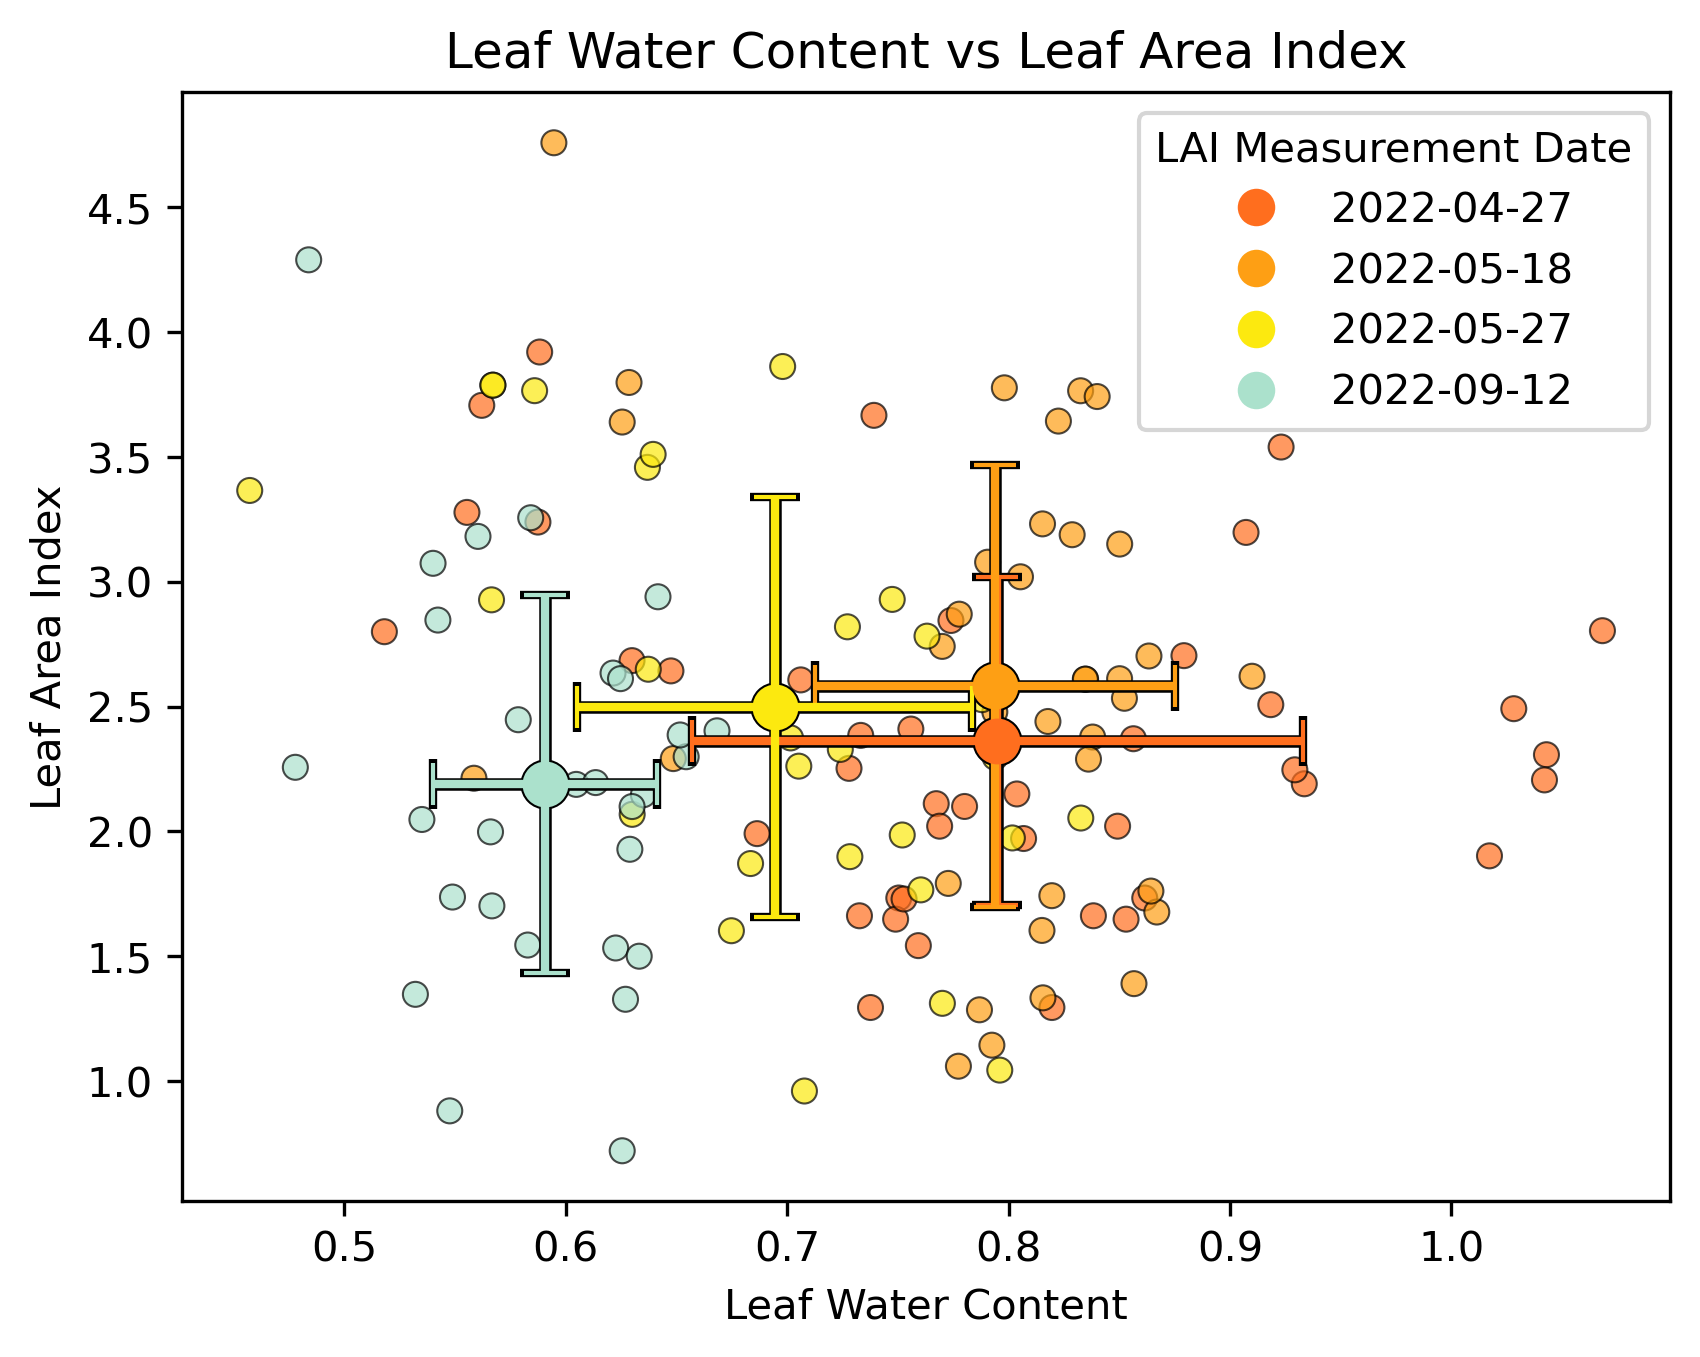

In [ ]:
# create colormap for dates
colors = ['#FF6E1EFF', '#FE9F14FF', '#FCE90FFF', '#ABE1CCFF']   # Camo 87 4 from PyPalettes, lightly edited
lai_colors = dict(zip(lai_dates, colors))

# plot all data, colored by date
plt.scatter(lwc['lwc_mean'], lwc['lai'], c=lwc['lai_date'].map(lai_colors), edgecolor='k', alpha=0.7, linewidth=0.5, zorder=0)
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label=str(date.date()),
                    markerfacecolor=color, markersize=10) for date, color in lai_colors.items()],
           title='LAI Measurement Date', loc='upper right')

# plot averages for each date
lwc_avgs = []
lwc_stdevs = []
lai_avgs = []
lai_stdevs = []
for date in lai_dates:
    lwc_date = lwc[lwc['lai_date'] == date]
    lwc_avgs.append(lwc_date['lwc_mean'].mean())
    lwc_stdevs.append(lwc_date['lwc_mean'].std())
    lai_avgs.append(lwc_date['lai'].mean())
    lai_stdevs.append(lwc_date['lai'].std())
    plt.errorbar(lwc_avgs[-1], lai_avgs[-1], xerr=lwc_stdevs[-1], yerr=lai_stdevs[-1],
             fmt='o', color=lai_colors[date], markersize=10, capsize=5, elinewidth=2, capthick=1, zorder=2)
    plt.errorbar(lwc_avgs[-1], lai_avgs[-1], xerr=lwc_stdevs[-1], yerr=lai_stdevs[-1],
             fmt='o', color='k', markersize=11, capsize=6, elinewidth=3, capthick=2, zorder=1)

plt.title('Leaf Water Content vs Leaf Area Index')

plt.xlabel('Leaf Water Content')
plt.ylabel('Leaf Area Index')

# plt.savefig('LWC_vs_LAI.png', bbox_inches='tight')
plt.show()

## 3. Calculating Coefficient of Variation for LAI

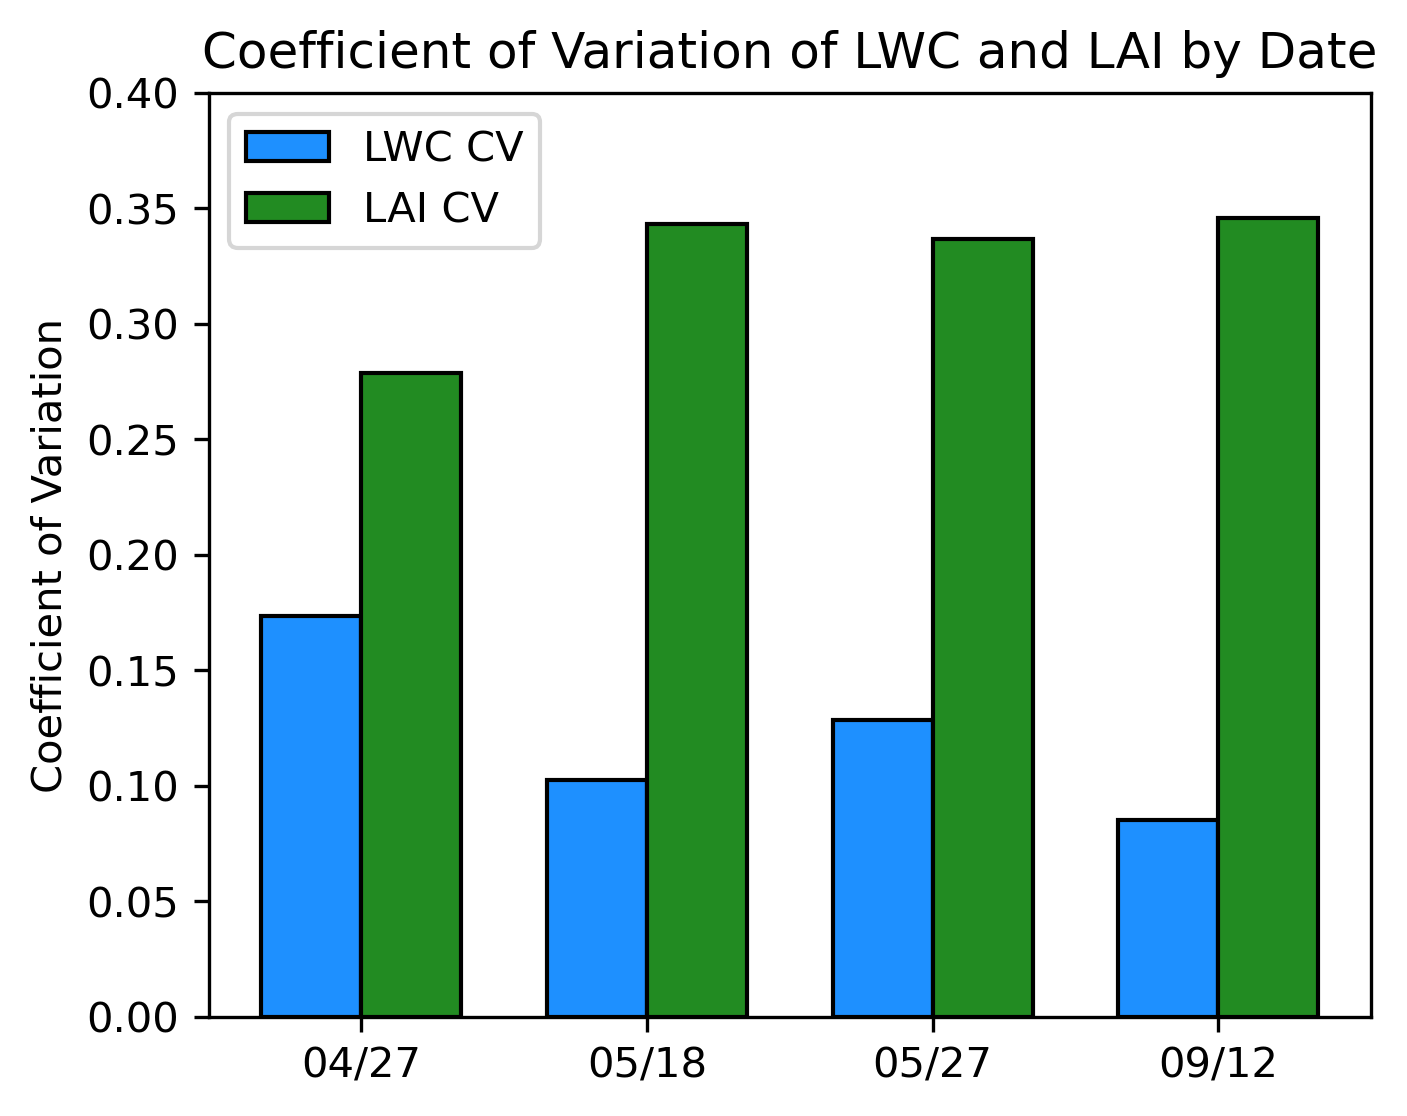

In [62]:
# start by calculating CVs for each date for LAI
lwc_cvs = []
lai_cvs = []

for date in lai_dates:
    lwc_this_date = lwc[lwc['lai_date'] == date]
    lwc_this_date_stdev = lwc_this_date['lwc_mean'].std()
    lwc_this_date_mean = lwc_this_date['lwc_mean'].mean()
    lwc_this_date_cv = lwc_this_date_stdev / lwc_this_date_mean
    lwc_cvs.append(lwc_this_date_cv)

    lai_this_date_stdev = lwc_this_date['lai'].std()
    lai_this_date_mean = lwc_this_date['lai'].mean()
    lai_this_date_cv = lai_this_date_stdev / lai_this_date_mean
    lai_cvs.append(lai_this_date_cv)

# bar chart of CVs for each date, with lai and lwc offset
fig, ax = plt.subplots(figsize=(5, 4))
x = np.arange(len(lai_dates))  # the label locations
width = 0.35  # the width of the bars

rects1 = ax.bar(x - width/2, lwc_cvs, width, label='LWC CV', color='dodgerblue', edgecolor='k')
rects2 = ax.bar(x + width/2, lai_cvs, width, label='LAI CV', color='forestgreen', edgecolor='k')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Coefficient of Variation')
ax.set_title('Coefficient of Variation of LWC and LAI by Date')
# format x-axis labels as dates MM/DD
ax.set_xticks(x)
ax.set_xticklabels([date.strftime('%m/%d') for date in lai_dates])
ax.legend(loc='upper left')
ax.set_ylim(0, 0.4)

# plt.savefig('CVs_across_space.png', bbox_inches='tight')
plt.show()

In [64]:
# now do CV for LAI and LWC for the four averages over time
lwc_cv_time = np.std(lwc_avgs) / np.mean(lwc_avgs)
lai_cv_time = np.std(lai_avgs) / np.mean(lai_avgs)

print('LWC CV over time:', lwc_cv_time)
print('LAI CV over time:', lai_cv_time)

LWC CV over time: 0.11739744610055476
LAI CV over time: 0.06163181055592975
